In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import random
import tensorflow as tf
import cv2
from scipy import stats



# Read Depth Camera

In [7]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video, nw_resize=1, nh_resize=1):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0])
    frame_width = int(frame.shape[1])

    
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize)))
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize),3))
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        
        if ret == True:
#             gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray_frame = frame/np.maximum(np.max(frame),255)
            gray_frame = cv2.resize(gray_frame, \
                                    (int(frame_width/nw_resize), int(frame_height/nh_resize)),\
                                    interpolation = cv2.INTER_NEAREST)

            depth_frames[count] = gray_frame
            if show_video == True:
                cv2.imshow("Depth", gray_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            count = count + 1
        else: 
            break
            

    video.release()
    #cv2.destroyAllWindows()
    return depth_frames

In [8]:
def play_video(read_frames):

    for i in range(len(read_frames)):
        # Capture frame-by-frame
        frame = read_frames[i]

        # Display the resulting frame
        plt.imshow(frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    #cv2.destroyAllWindows()

    return

In [9]:
def show_frame(read_frames, frame_range):
      # Capture frame-by-frame

    # Display the resulting frame
    for i in frame_range:
        fig = plt.figure(figsize=(6,6))        
        a = plt.imshow(read_frames[i])
        
    return

In [10]:
#fix this to concatenate everything
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test)+'.avi'
# show_video = 0
# n_resize = 1
# x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=2, nh_resize=3)


n_test = (24,25)
nw_resize = 4
nh_resize = 3
xtemp = {}
show_video = 0
for i in range(len(n_test)):
    test_str = '/test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + test_str
    train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test[i])+'.avi'
    x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=nw_resize, nh_resize=nh_resize)
    xtemp[i]=x_train

In [11]:
x_train.shape

(14668, 40, 40, 3)

In [12]:
tlen = len(xtemp[0])-2 +len(xtemp[1])-2 #remove 2 samples from 24
x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]))
x_train[:len(xtemp[0])-2,:,:,:] = xtemp[0][:len(xtemp[0])-2,:,:,:]
x_train[(len(xtemp[0])-2):,:,:,:] = xtemp[1][:len(xtemp[1])-2,:,:,:]

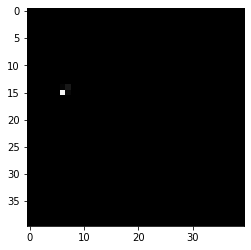

In [13]:
plt.imshow(x_train[-2])


## model.summary()

# read fdss data

In [14]:
#### Removed due to possible syncing/noise issue
# n_test = 24
# date = '11_15_2020'
# test_str = 'test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + "/" + test_str + "/fcss_processed_leo_" + test_str + "_" + date + ".txt"
# tmpdata = pd.read_csv(data_dir)

In [15]:
# tmpdata.head()

# Read Output Data


In [16]:
def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data


In [17]:
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# # data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# qtm_file_data_dir = data_dir + '/qtm_processed_leo_test' + str(n_test) + '_' + date + '.txt'
# #show_qtm_plot = True

# y_gt = read_output_data(qtm_file_data_dir,theta_interest).values
# theta_x = read_output_data(qtm_file_data_dir,'x').values
# theta_y = read_output_data(qtm_file_data_dir,'y').values
# theta_z = read_output_data(qtm_file_data_dir,'z').values

n_test = (24,25)
date = ('11_15_2020','11_19_2020')
y_gt = {}
theta_interest = 'z'
for i in range(len(n_test)):
    test_str = '/test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + test_str
    qtm_file_data_dir = data_dir + '/qtm_processed_leo_test' + str(n_test[i]) + '_' + date[i] + '.txt'
    y_gttemp = read_output_data(qtm_file_data_dir,theta_interest).values
    y_gt[i]=y_gttemp
    
tlen = len(y_gt[0])-2 +len(y_gt[1])-3 #remove 2 samples from 24 and 3 from 25
y_train = np.zeros((tlen,1))
y_train[:len(y_gt[0])-2] = y_gt[0][:len(y_gt[0])-2]
y_train[(len(y_gt[0])-2):] = y_gt[1][:len(y_gt[1])-3]

In [18]:
y_gt[0].shape

(12751, 1)

In [19]:
# Obtain X and Y data
# x_train.shape
# xtrainnew = pd.DataFrame(data=np.reshape(x_train, (x_train.shape[0],x_train.shape[1]*x_train.shape[2])))
# yframe = pd.DataFrame(data=y_train)

# TheData = pd.concat([xtrainnew,yframe],axis=1) #only contains video data
print(x_train.shape)
print(y_train.shape)

(27415, 40, 40, 3)
(27415, 1)


In [20]:
print(xtemp[0].shape)
print(y_gt[0].shape)
print(xtemp[1].shape)
print(y_gt[1].shape)

(12751, 40, 40, 3)
(12751, 1)
(14668, 40, 40, 3)
(14669, 1)


In [21]:
# xtmp = xtrainnew[300,:]
# plt.imshow(np.reshape(xtmp, (x_train.shape[1],x_train.shape[2])))

In [22]:
nsamps = x_train.shape[0]
n80p = int(np.floor(nsamps*0.8))
rannums = np.array(random.sample(range(1,nsamps,1), n80p))
s_nfiles = np.arange(nsamps)
test_set = np.setdiff1d(s_nfiles,rannums)

#

In [23]:
Trainset = x_train[rannums,:]
Testset = x_train[test_set,:]
# Trainy= y_gt[rannums,:]
# Testy = y_gt[test_set,:]
Trainy= y_train[rannums,:]
Testy = y_train[test_set,:]

In [24]:
sc_y = StandardScaler()

In [25]:
Xtrainz = Trainset
ytrainz = Trainy
X = Xtrainz
y = sc_y.fit_transform(ytrainz)

In [26]:
#make validation data available to model.fit
Xvalid = Testset

y_valid = Testy
y_valid = sc_y.transform(y_valid)


In [27]:
x_train.shape[1]

40

# Regress using Neural Network

In [28]:
np.min(Xvalid) #7min*30fps*60s/min*0.8 ~ 10800

0.0

In [29]:
# Create Neural Netowrk
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(X.shape[1],)))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# #model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# model.add(tf.keras.layers.Dropout(0.5))          
# model.add(tf.keras.layers.Dense(100, activation='linear')) #added extra layer. probably overkill but want good results
# model.add(tf.keras.layers.Dense(1, activation='linear'))
# model.compile(optimizer='adam',
#               loss='mae',
#               metrics=['mse','mae'])
    
# # loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # loss_fn(y_train[:1], predictions).numpy()

from keras.layers import Bidirectional, Conv2D, MaxPooling2D, Input, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Activation, Dropout, Reshape, Permute, Flatten
from keras.models import Model
batch_sz = 32
model_start = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
model_cnn = model_start
# f_pool_size = (5,2,2)
dropout_rate = 0.5
# for i, convCnt in enumerate(f_pool_size):
#     model_cnn = Conv2D(filters=x_train.shape[2], kernel_size=(3, 3))(model_cnn)
#     model_cnn = BatchNormalization()(model_cnn)
#     model_cnn = Activation('relu')(model_cnn)
#     model_cnn = MaxPooling2D(pool_size=(f_pool_size[i], f_pool_size[i]))(model_cnn)
#     model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3))(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = MaxPooling2D(pool_size=(5, 5))(model_cnn)
model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3))(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = MaxPooling2D(pool_size=(1, 1))(model_cnn)
model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3))(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = MaxPooling2D(pool_size=(1, 1))(model_cnn)
model_cnn = Dropout(dropout_rate)(model_cnn)


model_cnn = Flatten()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Dense(128)(model_cnn)
model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

# model_cnn = Dense(200)(model_cnn)
# model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

output = Dense(1)(model_cnn)
output = Activation('linear', name='thetaz_out')(output)
model = Model(inputs=model_start,outputs=output)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse','mae'])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True) #Moving to 1000 patience. 
model.summary()

Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 40, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 38, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 38, 38, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          36928     
_________________________________________________________________
activation_2 (Activation)    (None, 5, 5, 64)          0   

In [30]:
epochs = int(30000)
batch_size = 256
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True)
history = model.fit(X, y,batch_size=batch_size, epochs = epochs,callbacks = [callback],validation_data = (Xvalid, y_valid),verbose=2)

# model.save('depthforcemodel.h5')
#history.save('depthforcehist.h5')

Train on 21932 samples, validate on 5483 samples
Epoch 1/30000
 - 3s - loss: 0.6898 - mse: 0.9899 - mae: 0.6898 - val_loss: 0.6563 - val_mse: 0.9305 - val_mae: 0.6563
Epoch 2/30000
 - 1s - loss: 0.6723 - mse: 0.9527 - mae: 0.6723 - val_loss: 0.6448 - val_mse: 0.9064 - val_mae: 0.6448
Epoch 3/30000
 - 1s - loss: 0.6642 - mse: 0.9359 - mae: 0.6642 - val_loss: 0.6405 - val_mse: 0.9034 - val_mae: 0.6405
Epoch 4/30000
 - 1s - loss: 0.6596 - mse: 0.9297 - mae: 0.6596 - val_loss: 0.6370 - val_mse: 0.8934 - val_mae: 0.6370
Epoch 5/30000
 - 1s - loss: 0.6552 - mse: 0.9156 - mae: 0.6552 - val_loss: 0.6314 - val_mse: 0.8832 - val_mae: 0.6314
Epoch 6/30000
 - 1s - loss: 0.6529 - mse: 0.9095 - mae: 0.6529 - val_loss: 0.6309 - val_mse: 0.8726 - val_mae: 0.6309
Epoch 7/30000
 - 1s - loss: 0.6498 - mse: 0.9043 - mae: 0.6498 - val_loss: 0.6266 - val_mse: 0.8666 - val_mae: 0.6266
Epoch 8/30000
 - 1s - loss: 0.6472 - mse: 0.8973 - mae: 0.6472 - val_loss: 0.6250 - val_mse: 0.8572 - val_mae: 0.6250
Epoch 9

Epoch 70/30000
 - 1s - loss: 0.5602 - mse: 0.7017 - mae: 0.5602 - val_loss: 0.5197 - val_mse: 0.6400 - val_mae: 0.5197
Epoch 71/30000
 - 1s - loss: 0.5581 - mse: 0.6972 - mae: 0.5581 - val_loss: 0.5207 - val_mse: 0.6446 - val_mae: 0.5207
Epoch 72/30000
 - 1s - loss: 0.5583 - mse: 0.7019 - mae: 0.5583 - val_loss: 0.5194 - val_mse: 0.6352 - val_mae: 0.5194
Epoch 73/30000
 - 1s - loss: 0.5601 - mse: 0.7036 - mae: 0.5601 - val_loss: 0.5188 - val_mse: 0.6377 - val_mae: 0.5188
Epoch 74/30000
 - 1s - loss: 0.5573 - mse: 0.6968 - mae: 0.5573 - val_loss: 0.5210 - val_mse: 0.6393 - val_mae: 0.5210
Epoch 75/30000
 - 1s - loss: 0.5559 - mse: 0.6917 - mae: 0.5559 - val_loss: 0.5178 - val_mse: 0.6386 - val_mae: 0.5178
Epoch 76/30000
 - 1s - loss: 0.5563 - mse: 0.6912 - mae: 0.5563 - val_loss: 0.5185 - val_mse: 0.6334 - val_mae: 0.5185
Epoch 77/30000
 - 1s - loss: 0.5535 - mse: 0.6869 - mae: 0.5535 - val_loss: 0.5169 - val_mse: 0.6329 - val_mae: 0.5169
Epoch 78/30000
 - 1s - loss: 0.5573 - mse: 0.691

Epoch 139/30000
 - 1s - loss: 0.5330 - mse: 0.6464 - mae: 0.5330 - val_loss: 0.4905 - val_mse: 0.5866 - val_mae: 0.4905
Epoch 140/30000
 - 1s - loss: 0.5331 - mse: 0.6475 - mae: 0.5331 - val_loss: 0.4909 - val_mse: 0.5888 - val_mae: 0.4909
Epoch 141/30000
 - 1s - loss: 0.5288 - mse: 0.6427 - mae: 0.5288 - val_loss: 0.4916 - val_mse: 0.5906 - val_mae: 0.4916
Epoch 142/30000
 - 1s - loss: 0.5324 - mse: 0.6471 - mae: 0.5324 - val_loss: 0.4901 - val_mse: 0.5853 - val_mae: 0.4901
Epoch 143/30000
 - 1s - loss: 0.5306 - mse: 0.6445 - mae: 0.5306 - val_loss: 0.4895 - val_mse: 0.5845 - val_mae: 0.4895
Epoch 144/30000
 - 1s - loss: 0.5298 - mse: 0.6450 - mae: 0.5298 - val_loss: 0.4923 - val_mse: 0.5927 - val_mae: 0.4923
Epoch 145/30000
 - 1s - loss: 0.5313 - mse: 0.6445 - mae: 0.5313 - val_loss: 0.4883 - val_mse: 0.5831 - val_mae: 0.4883
Epoch 146/30000
 - 1s - loss: 0.5302 - mse: 0.6396 - mae: 0.5302 - val_loss: 0.4907 - val_mse: 0.5872 - val_mae: 0.4907
Epoch 147/30000
 - 1s - loss: 0.5295 - m

Epoch 208/30000
 - 1s - loss: 0.5155 - mse: 0.6172 - mae: 0.5155 - val_loss: 0.4805 - val_mse: 0.5733 - val_mae: 0.4805
Epoch 209/30000
 - 1s - loss: 0.5177 - mse: 0.6214 - mae: 0.5177 - val_loss: 0.4798 - val_mse: 0.5684 - val_mae: 0.4798
Epoch 210/30000
 - 1s - loss: 0.5161 - mse: 0.6166 - mae: 0.5161 - val_loss: 0.4776 - val_mse: 0.5697 - val_mae: 0.4776
Epoch 211/30000
 - 1s - loss: 0.5159 - mse: 0.6144 - mae: 0.5159 - val_loss: 0.4760 - val_mse: 0.5690 - val_mae: 0.4760
Epoch 212/30000
 - 1s - loss: 0.5156 - mse: 0.6163 - mae: 0.5156 - val_loss: 0.4790 - val_mse: 0.5702 - val_mae: 0.4790
Epoch 213/30000
 - 1s - loss: 0.5157 - mse: 0.6185 - mae: 0.5157 - val_loss: 0.4787 - val_mse: 0.5722 - val_mae: 0.4787
Epoch 214/30000
 - 1s - loss: 0.5164 - mse: 0.6200 - mae: 0.5164 - val_loss: 0.4779 - val_mse: 0.5720 - val_mae: 0.4779
Epoch 215/30000
 - 1s - loss: 0.5189 - mse: 0.6251 - mae: 0.5189 - val_loss: 0.4786 - val_mse: 0.5731 - val_mae: 0.4786
Epoch 216/30000
 - 1s - loss: 0.5126 - m

Epoch 277/30000
 - 1s - loss: 0.5067 - mse: 0.5979 - mae: 0.5067 - val_loss: 0.4694 - val_mse: 0.5525 - val_mae: 0.4694
Epoch 278/30000
 - 1s - loss: 0.5063 - mse: 0.5949 - mae: 0.5063 - val_loss: 0.4687 - val_mse: 0.5536 - val_mae: 0.4687
Epoch 279/30000
 - 1s - loss: 0.5084 - mse: 0.6015 - mae: 0.5084 - val_loss: 0.4710 - val_mse: 0.5588 - val_mae: 0.4710
Epoch 280/30000
 - 1s - loss: 0.5078 - mse: 0.6050 - mae: 0.5078 - val_loss: 0.4697 - val_mse: 0.5540 - val_mae: 0.4697
Epoch 281/30000
 - 1s - loss: 0.5042 - mse: 0.5925 - mae: 0.5042 - val_loss: 0.4708 - val_mse: 0.5562 - val_mae: 0.4708
Epoch 282/30000
 - 1s - loss: 0.5096 - mse: 0.6016 - mae: 0.5096 - val_loss: 0.4677 - val_mse: 0.5512 - val_mae: 0.4677
Epoch 283/30000
 - 1s - loss: 0.5063 - mse: 0.5972 - mae: 0.5063 - val_loss: 0.4683 - val_mse: 0.5526 - val_mae: 0.4683
Epoch 284/30000
 - 1s - loss: 0.5087 - mse: 0.6062 - mae: 0.5087 - val_loss: 0.4679 - val_mse: 0.5501 - val_mae: 0.4679
Epoch 285/30000
 - 1s - loss: 0.5032 - m

Epoch 346/30000
 - 1s - loss: 0.5028 - mse: 0.5910 - mae: 0.5028 - val_loss: 0.4675 - val_mse: 0.5487 - val_mae: 0.4675
Epoch 347/30000
 - 1s - loss: 0.5019 - mse: 0.5913 - mae: 0.5019 - val_loss: 0.4634 - val_mse: 0.5430 - val_mae: 0.4634
Epoch 348/30000
 - 1s - loss: 0.4963 - mse: 0.5760 - mae: 0.4963 - val_loss: 0.4647 - val_mse: 0.5400 - val_mae: 0.4647
Epoch 349/30000
 - 1s - loss: 0.4996 - mse: 0.5788 - mae: 0.4996 - val_loss: 0.4636 - val_mse: 0.5409 - val_mae: 0.4635
Epoch 350/30000
 - 1s - loss: 0.4999 - mse: 0.5858 - mae: 0.4999 - val_loss: 0.4632 - val_mse: 0.5412 - val_mae: 0.4632
Epoch 351/30000
 - 1s - loss: 0.4994 - mse: 0.5804 - mae: 0.4994 - val_loss: 0.4618 - val_mse: 0.5381 - val_mae: 0.4618
Epoch 352/30000
 - 1s - loss: 0.5017 - mse: 0.5842 - mae: 0.5017 - val_loss: 0.4629 - val_mse: 0.5392 - val_mae: 0.4629
Epoch 353/30000
 - 1s - loss: 0.5015 - mse: 0.5900 - mae: 0.5015 - val_loss: 0.4619 - val_mse: 0.5400 - val_mae: 0.4619
Epoch 354/30000
 - 1s - loss: 0.4963 - m

Epoch 415/30000
 - 1s - loss: 0.4933 - mse: 0.5685 - mae: 0.4933 - val_loss: 0.4568 - val_mse: 0.5313 - val_mae: 0.4568
Epoch 416/30000
 - 1s - loss: 0.4960 - mse: 0.5757 - mae: 0.4960 - val_loss: 0.4602 - val_mse: 0.5349 - val_mae: 0.4602
Epoch 417/30000
 - 1s - loss: 0.4939 - mse: 0.5692 - mae: 0.4939 - val_loss: 0.4557 - val_mse: 0.5322 - val_mae: 0.4557
Epoch 418/30000
 - 1s - loss: 0.4952 - mse: 0.5748 - mae: 0.4952 - val_loss: 0.4555 - val_mse: 0.5299 - val_mae: 0.4555
Epoch 419/30000
 - 1s - loss: 0.4936 - mse: 0.5675 - mae: 0.4936 - val_loss: 0.4551 - val_mse: 0.5307 - val_mae: 0.4551
Epoch 420/30000
 - 1s - loss: 0.4912 - mse: 0.5676 - mae: 0.4912 - val_loss: 0.4561 - val_mse: 0.5289 - val_mae: 0.4561
Epoch 421/30000
 - 1s - loss: 0.4919 - mse: 0.5690 - mae: 0.4919 - val_loss: 0.4542 - val_mse: 0.5260 - val_mae: 0.4542
Epoch 422/30000
 - 1s - loss: 0.4994 - mse: 0.5832 - mae: 0.4994 - val_loss: 0.4559 - val_mse: 0.5281 - val_mae: 0.4559
Epoch 423/30000
 - 1s - loss: 0.4934 - m

Epoch 484/30000
 - 1s - loss: 0.4893 - mse: 0.5627 - mae: 0.4893 - val_loss: 0.4546 - val_mse: 0.5242 - val_mae: 0.4546
Epoch 485/30000
 - 1s - loss: 0.4876 - mse: 0.5592 - mae: 0.4876 - val_loss: 0.4544 - val_mse: 0.5267 - val_mae: 0.4544
Epoch 486/30000
 - 1s - loss: 0.4916 - mse: 0.5668 - mae: 0.4916 - val_loss: 0.4541 - val_mse: 0.5231 - val_mae: 0.4541
Epoch 487/30000
 - 1s - loss: 0.4879 - mse: 0.5585 - mae: 0.4879 - val_loss: 0.4536 - val_mse: 0.5210 - val_mae: 0.4536
Epoch 488/30000
 - 1s - loss: 0.4897 - mse: 0.5623 - mae: 0.4897 - val_loss: 0.4534 - val_mse: 0.5241 - val_mae: 0.4534
Epoch 489/30000
 - 1s - loss: 0.4881 - mse: 0.5553 - mae: 0.4881 - val_loss: 0.4540 - val_mse: 0.5266 - val_mae: 0.4540
Epoch 490/30000
 - 1s - loss: 0.4888 - mse: 0.5601 - mae: 0.4888 - val_loss: 0.4535 - val_mse: 0.5253 - val_mae: 0.4535
Epoch 491/30000
 - 1s - loss: 0.4883 - mse: 0.5615 - mae: 0.4883 - val_loss: 0.4538 - val_mse: 0.5244 - val_mae: 0.4538
Epoch 492/30000
 - 1s - loss: 0.4907 - m

Epoch 553/30000
 - 1s - loss: 0.4890 - mse: 0.5656 - mae: 0.4890 - val_loss: 0.4503 - val_mse: 0.5168 - val_mae: 0.4503
Epoch 554/30000
 - 1s - loss: 0.4855 - mse: 0.5523 - mae: 0.4855 - val_loss: 0.4476 - val_mse: 0.5147 - val_mae: 0.4476
Epoch 555/30000
 - 1s - loss: 0.4854 - mse: 0.5547 - mae: 0.4854 - val_loss: 0.4478 - val_mse: 0.5170 - val_mae: 0.4478
Epoch 556/30000
 - 1s - loss: 0.4843 - mse: 0.5512 - mae: 0.4843 - val_loss: 0.4493 - val_mse: 0.5144 - val_mae: 0.4493
Epoch 557/30000
 - 1s - loss: 0.4840 - mse: 0.5531 - mae: 0.4840 - val_loss: 0.4502 - val_mse: 0.5223 - val_mae: 0.4502
Epoch 558/30000
 - 1s - loss: 0.4855 - mse: 0.5560 - mae: 0.4855 - val_loss: 0.4485 - val_mse: 0.5174 - val_mae: 0.4485
Epoch 559/30000
 - 1s - loss: 0.4843 - mse: 0.5555 - mae: 0.4843 - val_loss: 0.4481 - val_mse: 0.5184 - val_mae: 0.4481
Epoch 560/30000
 - 1s - loss: 0.4852 - mse: 0.5548 - mae: 0.4852 - val_loss: 0.4479 - val_mse: 0.5145 - val_mae: 0.4479
Epoch 561/30000
 - 1s - loss: 0.4838 - m

Epoch 622/30000
 - 1s - loss: 0.4791 - mse: 0.5440 - mae: 0.4791 - val_loss: 0.4486 - val_mse: 0.5158 - val_mae: 0.4486
Epoch 623/30000
 - 1s - loss: 0.4810 - mse: 0.5481 - mae: 0.4810 - val_loss: 0.4443 - val_mse: 0.5070 - val_mae: 0.4443
Epoch 624/30000
 - 1s - loss: 0.4807 - mse: 0.5462 - mae: 0.4807 - val_loss: 0.4435 - val_mse: 0.5079 - val_mae: 0.4435
Epoch 625/30000
 - 1s - loss: 0.4826 - mse: 0.5537 - mae: 0.4826 - val_loss: 0.4470 - val_mse: 0.5113 - val_mae: 0.4470
Epoch 626/30000
 - 1s - loss: 0.4793 - mse: 0.5444 - mae: 0.4793 - val_loss: 0.4484 - val_mse: 0.5158 - val_mae: 0.4484
Epoch 627/30000
 - 1s - loss: 0.4830 - mse: 0.5550 - mae: 0.4830 - val_loss: 0.4462 - val_mse: 0.5091 - val_mae: 0.4462
Epoch 628/30000
 - 1s - loss: 0.4820 - mse: 0.5496 - mae: 0.4820 - val_loss: 0.4454 - val_mse: 0.5097 - val_mae: 0.4454
Epoch 629/30000
 - 1s - loss: 0.4819 - mse: 0.5484 - mae: 0.4819 - val_loss: 0.4473 - val_mse: 0.5124 - val_mae: 0.4473
Epoch 630/30000
 - 1s - loss: 0.4823 - m

<function matplotlib.use(backend, *, force=True)>

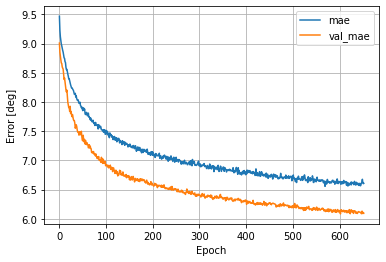

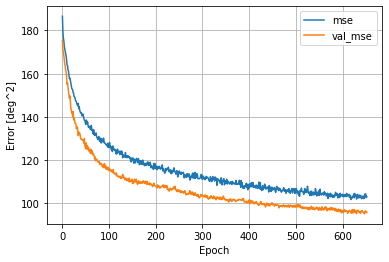

In [31]:
def plot_loss(history):
    
    v1 = history.history['mae']*np.sqrt(sc_y.var_)
    v2 = history.history['val_mae']*np.sqrt(sc_y.var_)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.plot(v1, label='mae')
    ax1.plot(v2, label='val_mae')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Error [deg]')
    ax1.legend()
    ax1.grid(True)
    plt.show()
    
    v3 = history.history['mse']*sc_y.var_
    v4 = history.history['val_mse']*sc_y.var_
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(v3, label='mse')
    ax2.plot(v4, label='val_mse')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Error [deg^2]')
    ax2.legend()
    ax2.grid(True)
    plt.show()
    
    
plot_loss(history)


### 4-layer Network: Predict Against Training Data as a Sanity Check

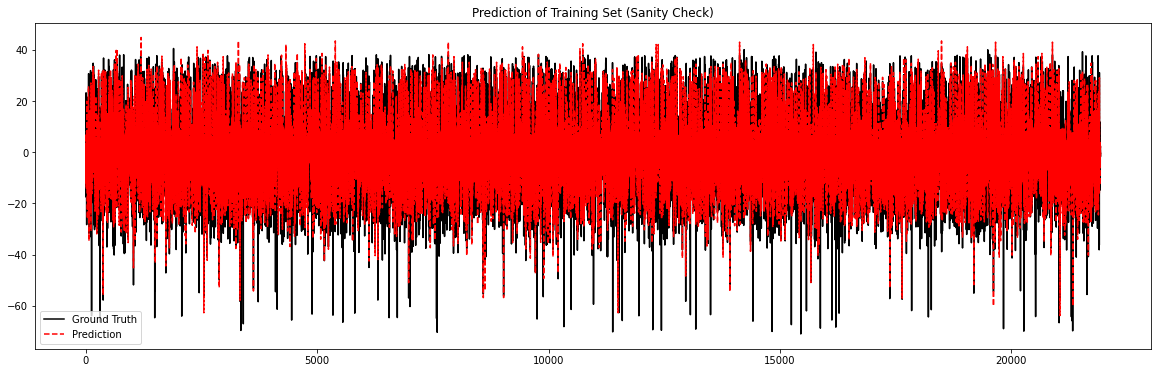

Average error is -0.05 degrees
Root Mean Squared Error is 5.14 degrees
Mean Absolute Error is 5.14 degrees


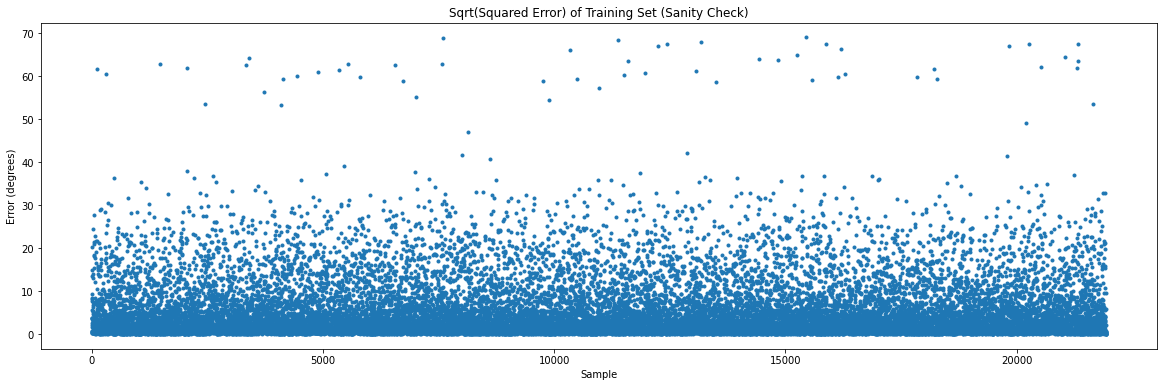

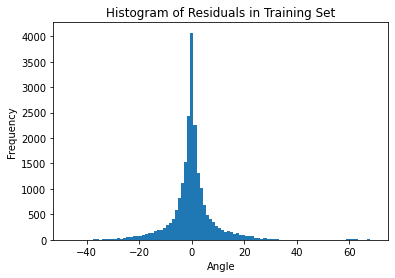

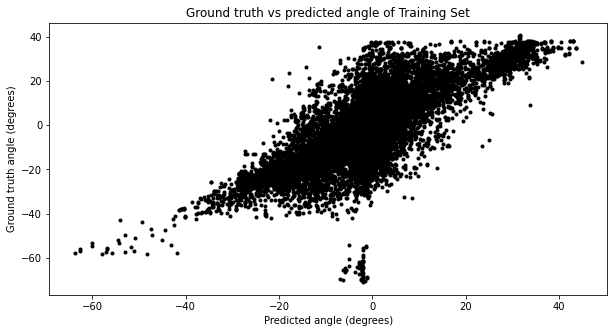

In [32]:

# sanity check with 80% data
Xtrain = Trainset
y_pred = model.predict(Xtrain)
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Trainy
plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Training Set (Sanity Check)')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()
# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Training Set (Sanity Check)')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Training Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle of Training Set')
plt.show()

### 4-layer Neural Network: Predict Test Set

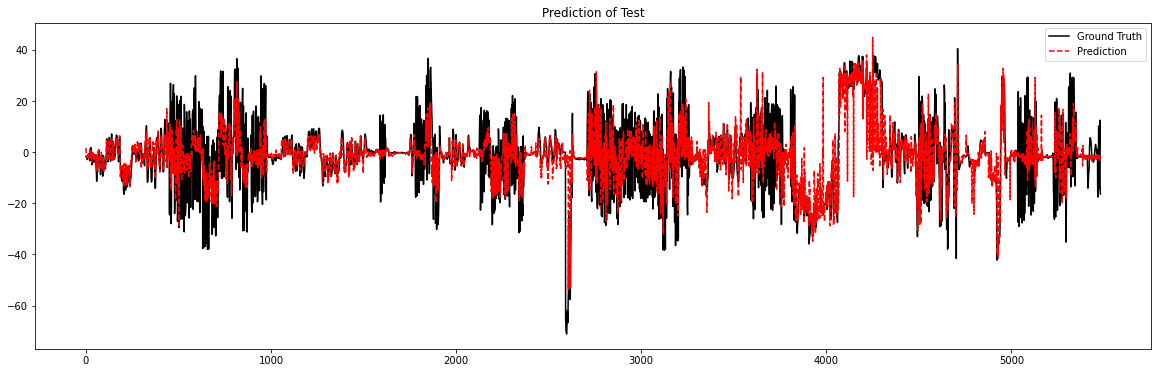

Average error is -0.14 degrees
Root Mean Squared Error is 6.08 degrees
Mean Absolute Error is 6.08 degrees


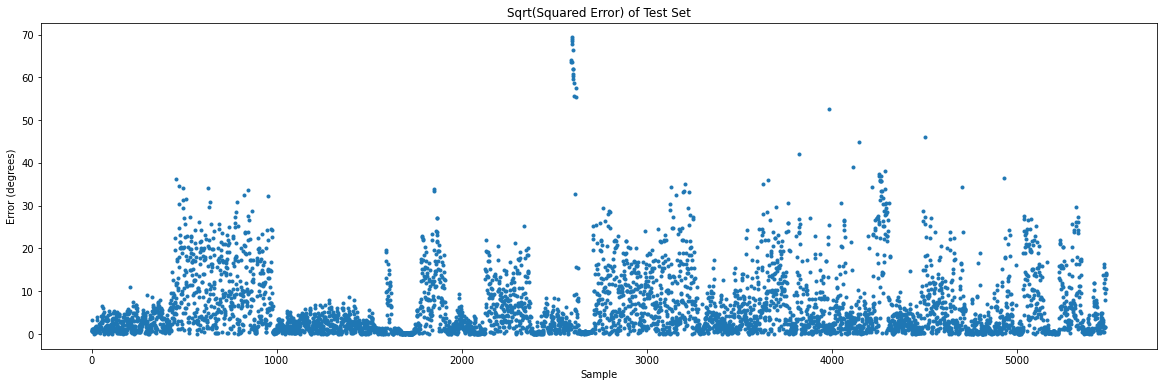

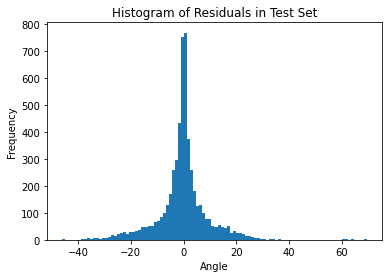

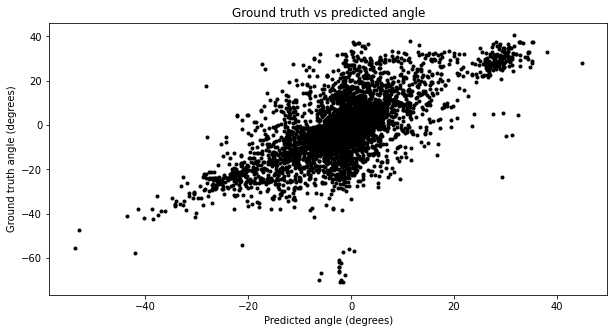

In [33]:
# Redo test set
Xtest = Testset
y_pred = model.predict(Xtest)
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Testy

plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()

# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Test Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Test Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle')
plt.show()

In [561]:
save_notebookparams = 1
if save_notebookparams:
    pkl_filename = "depthforcemodelparam_cnn3v6.pkl"
    randata = {}
    randata['nsamps']=nsamps
    randata['n80p']=n80p
    randata['rannums']=rannums
    randata['test_set']=test_set
    modelhistory = history.history
    
    
    with open(pkl_filename, 'wb') as file:
        pickle.dump([randata,sc_y,modelhistory], file)
        
    model.save('depthforcemodel_cnn3v6.h5') 